##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using the Meta-Dataset Data Pipeline

This notebook shows how to use `meta_dataset`’s input pipeline to sample data for the Meta-Dataset benchmark. There are two main ways in which data is sampled:
1. **episodic**:  Returns N-way classification *episodes*, which contain a *support* (training) set and a *query* (test) set. The number of classes (N) may vary from episode to episode.
2. **batch**:  Returns batches of images and their corresponding label, sampled from all available classes.

We first import `meta_dataset` and other required packages, and define utility functions for visualization. We’ll make use of `meta_dataset.data.learning_spec` and `meta_dataset.data.pipeline`; their purpose will be made clear later on.

In [2]:
#@title Imports and Utility Functions
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from collections import Counter
import gin
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from meta_dataset.data import config
from meta_dataset.data import dataset_spec as dataset_spec_lib
from meta_dataset.data import learning_spec
from meta_dataset.data import pipeline


def plot_episode(support_images, support_class_ids, query_images,
                 query_class_ids, size_multiplier=1, max_imgs_per_col=10,
                 max_imgs_per_row=10):
  for name, images, class_ids in zip(('Support', 'Query'),
                                     (support_images, query_images),
                                     (support_class_ids, query_class_ids)):
    n_samples_per_class = Counter(class_ids)
    n_samples_per_class = {k: min(v, max_imgs_per_col)
                           for k, v in n_samples_per_class.items()}
    id_plot_index_map = {k: i for i, k
                         in enumerate(n_samples_per_class.keys())}
    num_classes = min(max_imgs_per_row, len(n_samples_per_class.keys()))
    max_n_sample = max(n_samples_per_class.values())
    figwidth = max_n_sample
    figheight = num_classes
    if name == 'Support':
      print('#Classes: %d' % len(n_samples_per_class.keys()))
    figsize = (figheight * size_multiplier, figwidth * size_multiplier)
    fig, axarr = plt.subplots(
        figwidth, figheight, figsize=figsize)
    fig.suptitle('%s Set' % name, size='20')
    fig.tight_layout(pad=3, w_pad=0.1, h_pad=0.1)
    reverse_id_map = {v: k for k, v in id_plot_index_map.items()}
    for i, ax in enumerate(axarr.flat):
      ax.patch.set_alpha(0)
      # Print the class ids, this is needed since, we want to set the x axis
      # even there is no picture.
      ax.set(xlabel=reverse_id_map[i % figheight], xticks=[], yticks=[])
      ax.label_outer()
    for image, class_id in zip(images, class_ids):
      # First decrement by one to find last spot for the class id.
      n_samples_per_class[class_id] -= 1
      # If class column is filled or not represented: pass.
      if (n_samples_per_class[class_id] < 0 or
          id_plot_index_map[class_id] >= max_imgs_per_row):
        continue
      # If width or height is 1, then axarr is a vector.
      if axarr.ndim == 1:
        ax = axarr[n_samples_per_class[class_id]
                   if figheight == 1 else id_plot_index_map[class_id]]
      else:
        ax = axarr[n_samples_per_class[class_id], id_plot_index_map[class_id]]
      ax.imshow(image / 2 + 0.5)
    plt.show()


def plot_batch(images, labels, size_multiplier=1):
  num_examples = len(labels)
  figwidth = np.ceil(np.sqrt(num_examples)).astype('int32')
  figheight = num_examples // figwidth
  figsize = (figwidth * size_multiplier, (figheight + 1.5) * size_multiplier)
  _, axarr = plt.subplots(figwidth, figheight, dpi=300, figsize=figsize)

  for i, ax in enumerate(axarr.transpose().ravel()):
    # Images are between -1 and 1.
    ax.imshow(images[i] / 2 + 0.5)
    ax.set(xlabel=labels[i], xticks=[], yticks=[])
  plt.show()

# Primers
1. Download your data and process it as explained in [link](https://github.com/google-research/meta-dataset/blob/master/README.md#downloading-and-converting-datasets). Set `BASE_PATH` pointing the processed tf-records (`$RECORDS` in the conversion instructions).
2. `meta_dataset` supports many different setting for sampling data. We use [gin-config](https://github.com/google/gin-config) to control default parameters of our functions. You can go to default gin file we are pointing and see the default values.
3. You can use `meta_dataset` in **eager** or **graph** mode.
4. Let's write a generator that makes the right calls to return data from dataset. `dataset.make_one_shot_iterator()` returns an iterator where each element is an episode.
4. SPLIT is used to define which part of the meta-split is going to be used. Different splits have different classes and the details on how they are created can be found in the [paper](https://arxiv.org/abs/1903.03096).

In [11]:
# 1
BASE_PATH = './record'
GIN_FILE_PATH = 'meta_dataset/learn/gin/setups/data_config.gin'
# 2
gin.parse_config_file(GIN_FILE_PATH)
# 3
# Comment out to disable eager execution.
#tf.enable_eager_execution()
# 4
def iterate_dataset(dataset, n):
  if not tf.executing_eagerly():
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    with tf.Session() as sess:
      for idx in range(n):
        yield idx, sess.run(next_element)
  else:
    for idx, episode in enumerate(dataset):
      if idx == n:
        break
      yield idx, episode
# 5
SPLIT = learning_spec.Split.TRAIN
print(SPLIT)

Split.TRAIN


# Reading datasets
In order to sample data, we need to read the dataset_spec files for each dataset. Following snippet reads those files into a list. 

In [5]:
ALL_DATASETS = ['aircraft', 'cu_birds', 'dtd', 'fungi', 'ilsvrc_2012',
                'omniglot', 'quickdraw', 'vgg_flower']

ALL_DATASETS = ['cu_birds']
all_dataset_specs = []
for dataset_name in ALL_DATASETS:
  dataset_records_path = os.path.join(BASE_PATH, dataset_name)
  dataset_spec = dataset_spec_lib.load_dataset_spec(dataset_records_path)
  all_dataset_specs.append(dataset_spec)

# (1) Episodic Mode
`meta_dataset` uses [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API and it takes one call to `pipeline.make_multisource_episode_pipeline()`. We loaded or defined most of the variables used during this call above. The remaining parameters are explained below:

- **use_bilevel_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use bilevel ontology. Omniglot is set up with a hierarchy with two level: the alphabet (Latin, Inuktitut...), and the character (with 20 examples per character).
The flag means that each episode will contain classes from a single alphabet. 
- **use_dag_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use dag_ontology. Same idea for ImageNet, except it uses the hierarchical sampling procedure described in the article.
- **image_size**: All images from various datasets are down or upsampled to the same size. This is the flag controls the edge size of the square.

In [7]:
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
# Enable ontology aware sampling for Omniglot and ImageNet. 
#use_bilevel_ontology_list[5] = True
#use_dag_ontology_list[4] = True
variable_ways_shots = config.EpisodeDescriptionConfig(
    num_query=None, num_support=None, num_ways=None)

dataset_episodic = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=all_dataset_specs,
    use_dag_ontology_list=use_dag_ontology_list,
    use_bilevel_ontology_list=use_bilevel_ontology_list,
    episode_descr_config=variable_ways_shots,
    split=SPLIT, image_size=84)

## Using Dataset
1. The episodic dataset consist in a tuple of the form (Episode, data source ID). The data source ID is an integer Tensor containing a value in the range [0, len(all_dataset_specs) - 1]
signifying which of the datasets of the multisource pipeline the given episode
came from. Episodes consist of support and query sets and we want to learn to classify images at the query set correctly given the support images. For both support and query set we have `images`, `labels` and `class_ids`. Labels are transformed class_ids offset to zero, so that global class_ids are set to \[0, N\] where N is the number of classes in an episode.
3. As one can see the number of images in query set and support set is different. Images are scaled, copied into 84\*84\*3 tensors. Labels are presented in two forms:
   * `*_labels` are relative to the classes selected for the current episode only. They are used as targets for this episode.
   * `*_class_ids` are the original class ids relative to the whole dataset. They are used for visualization and diagnostics.
4. It easy to convert tensors of the episode into numpy arrays and use them outside of the Tensorflow framework.
5. Classes might have different number of samples in the support set, whereas each class has 10 samples in the query set. 


In [8]:
# 1
idx, (episode, source_id) = next(iterate_dataset(dataset_episodic, 1))
print('Got an episode from dataset:', all_dataset_specs[source_id].name)

# 2
for t, name in zip(episode,
                   ['support_images', 'support_labels', 'support_class_ids',
                    'query_images', 'query_labels', 'query_class_ids']):
  print(name, t.shape)

# 3
episode = [a.numpy() for a in episode]

# 4
support_class_ids, query_class_ids = episode[2], episode[5]
print(Counter(support_class_ids))
print(Counter(query_class_ids))

Got an episode from dataset: cu_birds
support_images (481, 84, 84, 3)
support_labels (481,)
support_class_ids (481,)
query_images (350, 84, 84, 3)
query_labels (350,)
query_class_ids (350,)
Counter({41: 24, 92: 24, 9: 24, 32: 23, 64: 22, 43: 21, 24: 21, 136: 20, 47: 20, 62: 19, 101: 19, 6: 16, 104: 15, 132: 14, 106: 13, 127: 13, 57: 13, 88: 12, 2: 12, 96: 12, 33: 10, 23: 10, 83: 9, 111: 9, 37: 9, 39: 9, 40: 9, 130: 8, 61: 8, 45: 8, 51: 7, 14: 7, 60: 7, 128: 7, 114: 7})
Counter({51: 10, 83: 10, 136: 10, 111: 10, 47: 10, 14: 10, 88: 10, 64: 10, 37: 10, 106: 10, 60: 10, 43: 10, 39: 10, 130: 10, 40: 10, 128: 10, 41: 10, 32: 10, 114: 10, 6: 10, 92: 10, 104: 10, 2: 10, 127: 10, 33: 10, 61: 10, 57: 10, 24: 10, 96: 10, 62: 10, 101: 10, 23: 10, 45: 10, 132: 10, 9: 10})


## Visualizing Episodes
Let's visualize the episodes. 

- Support and query set for each episode plotted sequentially. Set N_EPISODES to control number of episodes visualized.
- Each episode is sampled from a single dataset and include N different classes. Each class might have different number of samples in support set, whereas number of images in query set is fixed. We limit number of classes and images per class to 10 in order to create legible plots. Actual episodes might have more classes and samples.  
- Each column represents a distinct class and dataset specific class ids are plotted on the x_axis.

Episode id: 0 from source cu_birds
#Classes: 16


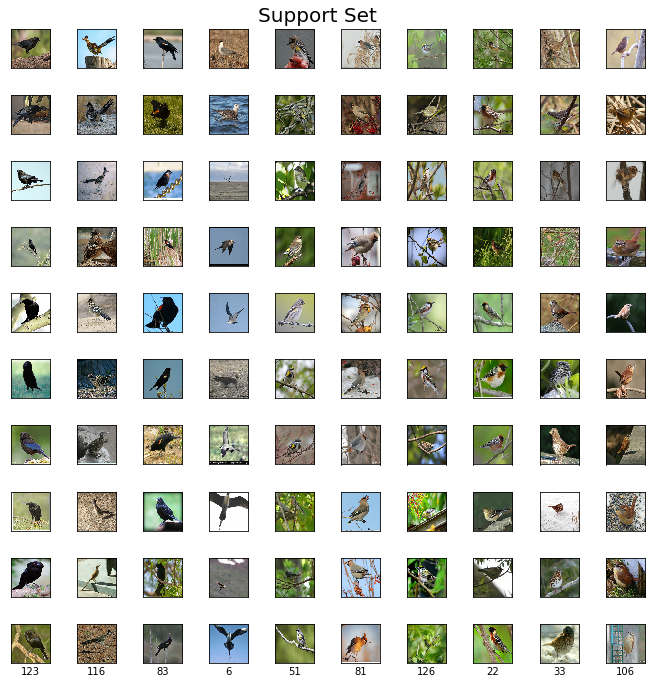

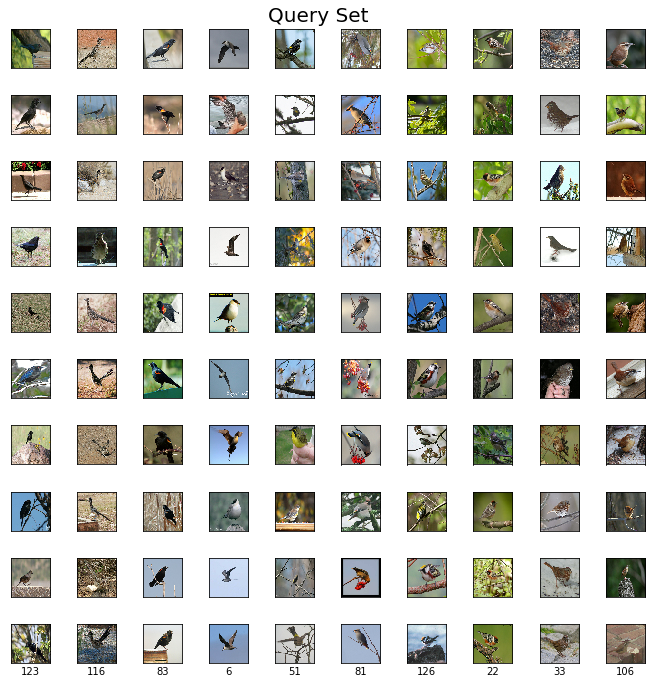

Episode id: 1 from source cu_birds
#Classes: 39


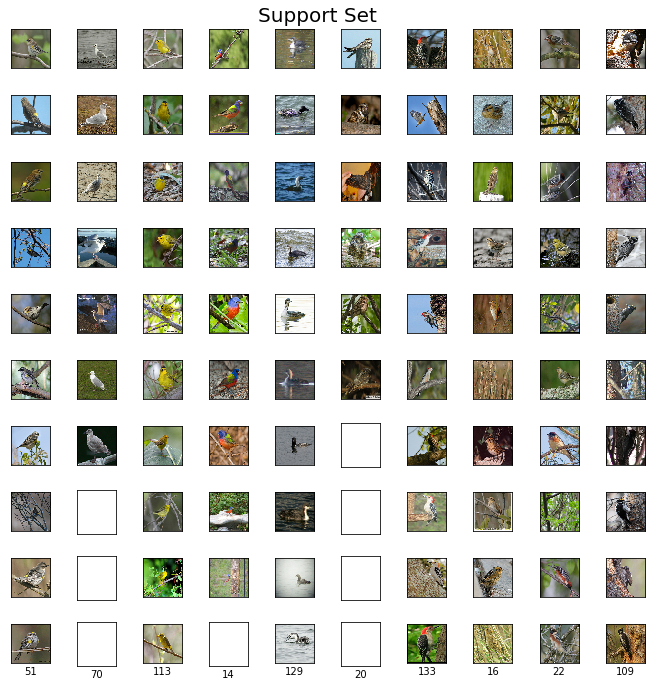

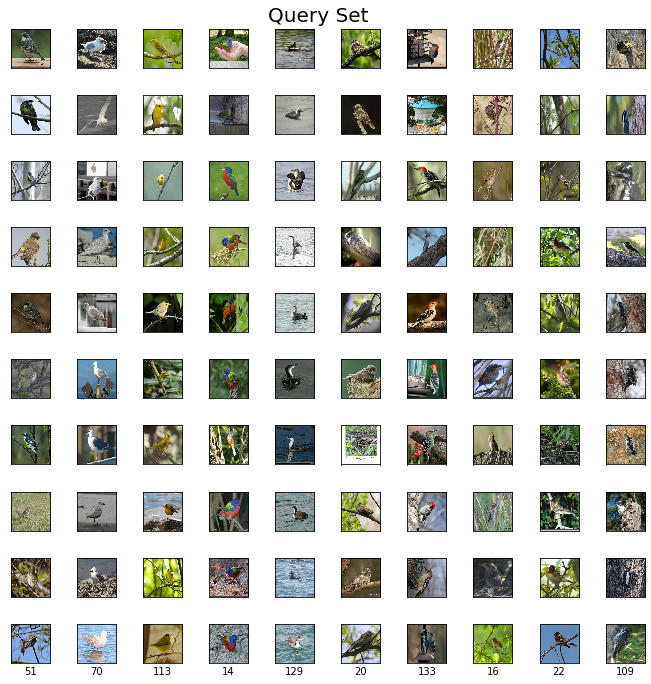

In [10]:
# 1
N_EPISODES=2
# 2, 3
for idx, (episode, source_id) in iterate_dataset(dataset_episodic, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, all_dataset_specs[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (2) Batch Mode
Second mode that `meta_dataset` library provides is the batch mode, where one can sample batches from the list of  datasets in a non-episodic manner and use it to train baseline models. There are couple things to note here:

- Each batch is sampled from a different dataset.
- `ADD_DATASET_OFFSET` controls whether the class_id's returned by the iterator overlaps among different datasets or not. A dataset specific offset is added in order to make returned ids unique.
- `make_multisource_batch_pipeline()` creates a `tf.data.Dataset` object that returns datasets of the form (Batch, data source ID) where similarly to the
episodic case, the data source ID is an integer Tensor that identifies which
dataset the given batch originates from.

In [12]:
BATCH_SIZE = 16
ADD_DATASET_OFFSET = True

In [13]:
dataset_batch = pipeline.make_multisource_batch_pipeline(
    dataset_spec_list=all_dataset_specs, batch_size=BATCH_SIZE, split=SPLIT,
    image_size=84, add_dataset_offset=ADD_DATASET_OFFSET)

for idx, ((images, labels), source_id) in iterate_dataset(dataset_batch, 1):
  print(images.shape, labels.shape)

(16, 84, 84, 3) (16,)


Batch-0 from source cu_birds


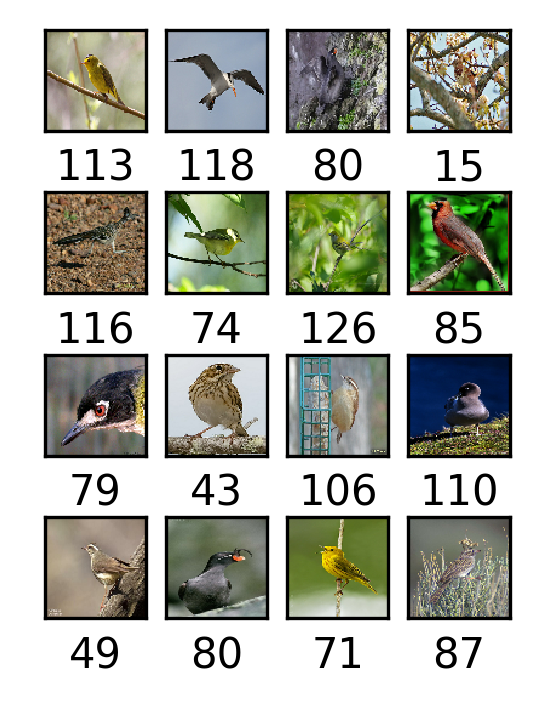

Batch-1 from source cu_birds


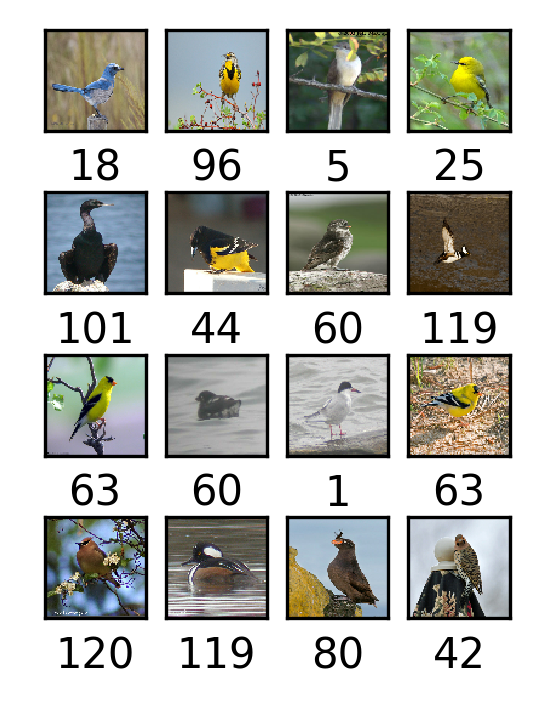

In [14]:
N_BATCH = 2
for idx, (batch, source_id) in iterate_dataset(dataset_batch, N_BATCH):
  print('Batch-%d from source %s' % (idx, all_dataset_specs[source_id].name))
  plot_batch(*map(lambda a: a.numpy(), batch), size_multiplier=0.5)

# (3) Fixing Ways and Shots
1. `meta_dataset` library provides option to set number of classes/samples per episode. There are 3 main flags you can set. 
    - **NUM_WAYS**: Fixes the # classes per episode. We would still get variable number of samples per class in the support set.
    - **NUM_SUPPORT**: Fixes # samples per class in the support set.
    - **NUM_QUERY**: Fixes # samples per class in the query set.
2. If we want to use fixed `num_ways`, we have to disable ontology based sampling for omniglot and imagenet. We advise using single dataset for using this feature, since using multiple datasets is not supported/tested. In this notebook, we are using Quick, Draw! Dataset.
3. We sample episodes and visualize them as we did earlier.

Episode id: 0 from source cu_birds
#Classes: 8


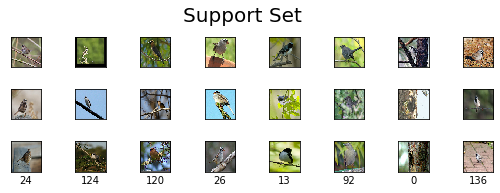

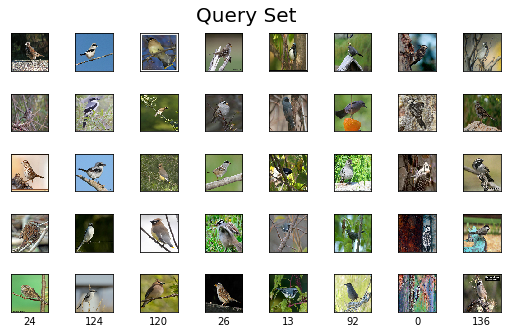

Episode id: 1 from source cu_birds
#Classes: 8


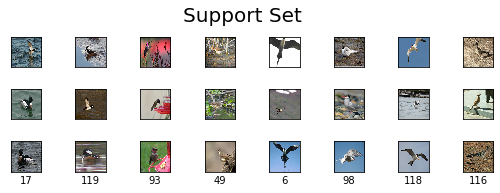

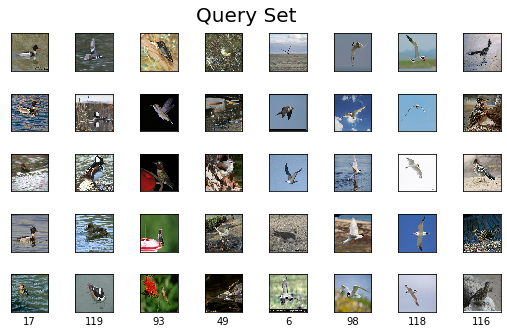

In [16]:
#1
NUM_WAYS = 8
NUM_SUPPORT = 3
NUM_QUERY = 5
fixed_ways_shots = config.EpisodeDescriptionConfig(
    num_ways=NUM_WAYS, num_support=NUM_SUPPORT, num_query=NUM_QUERY)

#2
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
quickdraw_spec = [all_dataset_specs[0]]
#3
dataset_fixed = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=quickdraw_spec, use_dag_ontology_list=[False],
    use_bilevel_ontology_list=use_bilevel_ontology_list, split=SPLIT,
    image_size=84, episode_descr_config=fixed_ways_shots)

N_EPISODES = 2
for idx, (episode, source_id) in iterate_dataset(dataset_fixed, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, quickdraw_spec[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (4) Using Meta-dataset with PyTorch
As mentioned above it is super easy to consume `meta_dataset` as NumPy arrays. This also enables easy integration into other popular deep learning frameworks like PyTorch. TensorFlow code processes the data and passes it to PyTorch, ready to be consumed. Since the data loader and processing steps do not have any operation on the GPU, TF should not attempt to grab the GPU, and it should be available for PyTorch.
1. Let's use an episodic dataset created earlier, `dataset_episodic`, and build on top of it. We will transpose tensor to CHW, which is the common order used by [convolutional layers](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.functional.conv2d) of PyTorch. 
2. We will use zero-indexed labels, therefore grabbing `e[1]` and `e[4]`. At the end we return a generator that consumes the `tf.Dataset`. 
3. Using `.cuda()` on PyTorch tensors should distribute them to appropriate devices.


In [17]:
import torch
# 1
to_torch_labels = lambda a: torch.from_numpy(a.numpy()).long()
to_torch_imgs = lambda a: torch.from_numpy(np.transpose(a.numpy(), (0, 3, 1, 2)))
# 2
def data_loader(n_batches):
  for i, (e, _) in enumerate(dataset_episodic):
    if i == n_batches:
      break
    yield (to_torch_imgs(e[0]), to_torch_labels(e[1]),
           to_torch_imgs(e[3]), to_torch_labels(e[4]))

for i, batch in enumerate(data_loader(n_batches=2)):
  #3
  data_support, labels_support, data_query, labels_query = [x.cuda() for x in batch]
  print(data_support.shape, labels_support.shape, data_query.shape, labels_query.shape) 

ModuleNotFoundError: No module named 'torch'